# 0. change

data_loader add folder args

# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import random
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
import os
import shutil

ctx = mx.gpu(0)

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data loader, data argument

In [2]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')

def load_all_data_label(pathes):
    all_data, all_label = None, None
    for path in pathes:
        data, label = nd.load(path)
        label = label.reshape((-1,)).astype('float32')
        if all_data is None:
            all_data, all_label = data, label
        else:
            all_data = nd.concat(all_data, data, dim=0)
            all_label = nd.concat(all_label, label, dim=0)
    return all_data, all_label


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0, pathes=None, arrayds=False):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    if pathes is None:
        train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=transform_train)
    else:
        if not arrayds:
            train_ds = MultiFolderDataset(pathes, transform=transform_train)
        else:
            train_ds = MyArrayDataset(load_all_data_label(pathes), transform=transform_train)
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep', num_workers=num_workers)
    return train_data, test_data

In [3]:
"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def transform_train_DA2(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
                                mean=np.array([0.4914, 0.4822, 0.4465]),
                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))
    
    for aug in auglist:
        im = aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
    

random_clip_rate = 0.3
def transform_train_DA3(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
#                                mean=np.array([0.4914, 0.4822, 0.4465]),
#                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))

    for aug in auglist:
        im = aug(im)
        
    if random.random() > random_clip_rate:
        im = im.clip(0, 1)
    _aug = image.ColorNormalizeAug(mean=np.array([0.4914, 0.4822, 0.4465]),
                   std=np.array([0.2023, 0.1994, 0.2010]),)
    im = _aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))

# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

## 3.1 mixup: define

In [4]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1, num_class)
    y2 = nd.one_hot(y2, num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

## 3.2 mixup: visulize

In [5]:
from mxnet import gluon
from mxnet.gluon.model_zoo import vision as model
from time import time
batch_size = 32
transform_train = _transform_test#transform_train_DA1
train_data, test_data = data_loader(batch_size, transform_train)
mixup_alpha = 1

# for x1, y1 in train_data:
#     for x2, y2 in mixup_train_data:
#         data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
#         break
#     break

for x, y in train_data:
    l = x.shape[0] / 2
    data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
    break

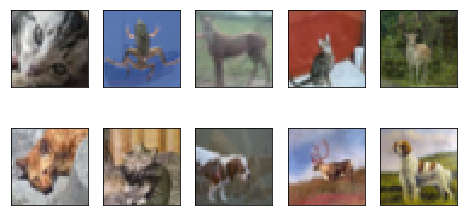

[(0, 'airplane'), (1, 'automobile'), (2, 'bird'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'frog'), (7, 'horse'), (8, 'ship'), (9, 'truck')]

[[[ 0.          0.          0.          0.85015678  0.          0.          0.
    0.          0.14984323  0.        ]]

 [[ 0.          0.          0.          0.          0.          0.
    0.85015678  0.          0.14984323  0.        ]]

 [[ 0.          0.          0.          0.          0.14984323  0.          0.
    0.85015678  0.          0.        ]]

 [[ 0.          0.          0.          0.85015678  0.          0.14984323
    0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.          0.85015678  0.          0.
    0.          0.          0.14984323]]

 [[ 0.          0.          0.          0.85015678  0.          0.          0.
    0.          0.          0.14984323]]

 [[ 0.          0.          0.          0.85015678  0.14984323  0.          0.
    0.          0.          0.        ]]

 [[

In [6]:
from cifar10_utils import show_images
%matplotlib inline
mean=np.array([0.4914, 0.4822, 0.4465])
std=np.array([0.2023, 0.1994, 0.2010])
images = data[:10].transpose((0, 2, 3, 1)).asnumpy()
images = images * std + mean
images = images.transpose((0, 3, 1, 2)) * 255
show_images(images)
#show_images(data[:9], rgb_mean=mean*255, std=std*255)

print [(i, l) for i, l in enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])]
print label[:10]

## 3.3 mixup: train

In [7]:
from time import time
mixup_test = False

if mixup_test:
    net = ResNet164_v2(10)
    net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
    loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

    num_epochs = 1
    learning_rate = 0.1
    weight_decay = 1e-4

    cur_time = time()
    iters = 0
    """
    data loader first time run will cost about 3x time than after run.
    """
    for x1, y1 in train_data:
        if iters % 100 == 0:
            print iters, time() - cur_time
        iters += 1
    print "cost time:", time() - cur_time
    print
    cur_time = time()

    iters = 0
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
    for x, y in train_data:
        l = x.shape[0] / 2
        data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)

        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label.as_in_context(ctx))
        loss.backward()
        trainer.step(data.shape[0])

        if iters % 100 == 0:
            print iters, time() - cur_time, nd.mean(loss).asscalar()
        iters += 1
    print iters, time() - cur_time

    # load data one by one batch
    # iters = 0
    # for x1, y1 in train_data:
    #     for x2, y2 in mixup_train_data:
    #         data, label = mixup(x1, y1, x2[:x1.shape[0]], y2[:y1.shape[0]], mixup_alpha, 10)
    #         break
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time
    #     iters += 1
    # print "cost time:", time() - cur_time
    # print
    # cur_time = time()

    # zip will load all datas and then iterate them, too cost memory, will drop speed when memory over.
    # iters = 0
    # for (x1, y1), (x2, y2) in zip(train_data, mixup_train_data):
    #     data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time#, nd.mean(loss).asscalar()
    #     iters += 1
    # print time() - cur_time

# 3. data augment: back grad

## 3.1 define a simple back grad method

In [5]:
from cifar10_utils import show_images
%matplotlib inline

def SGD(data, lr):
    data[:] = data - data.grad * lr
    
def inv_normalize(data, clip=True):
    mean=np.array([0.4914, 0.4822, 0.4465])
    std=np.array([0.2023, 0.1994, 0.2010])
    images = data.transpose((0, 2, 3, 1)).asnumpy()
    images = images * std + mean
    images = images.transpose((0, 3, 1, 2)) * 255
    if clip: 
        images = images.clip(0, 255)
    return images
    
def show_data(data, clip=True):
    images = inv_normalize(data, clip)
    show_images(images)
    
def generate_backgrad_data(net, data, label, max_iters=60, lr=0.1, iter_log=False, clip=True, combine_batch=False):
    for iters in range(1, max_iters+1):
        with autograd.record():
            data.attach_grad()
            output = net(data.as_in_context(ctx))
            loss = -loss_f(output, label.as_in_context(ctx))
        loss.backward()
        
        if iter_log and iters % 50 == 0:
            show_data(data[:10], clip)
            print data[0, 0, :2, :10]
            print data.grad[0, 0, :2, :10]
        if iter_log and iters % 5 == 0:
            print 'iter:', iters, 'loss:', nd.mean(loss).asscalar()
        
        SGD(data, lr)
    return data, (nd.mean(loss).asscalar(),)

## 3.2 view result

In [9]:
net = ResNet(10)
net.load_params('../../models/resnet18_me_200e', ctx=ctx)
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
for data, label in train_data:
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    break

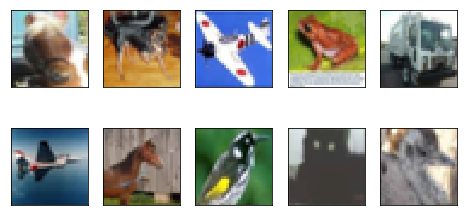

iter: 5 loss: -0.653574
iter: 10 loss: -8.564
iter: 15 loss: -20.576
iter: 20 loss: -24.9794
iter: 25 loss: -27.0003
iter: 30 loss: -28.422
iter: 35 loss: -29.5991
iter: 40 loss: -30.2958
iter: 45 loss: -30.7695


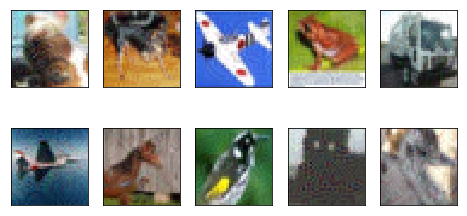


[[ 0.84831941  0.43412015  0.055559    0.40172759  0.22163963  0.3280842
   0.43882918  0.57305658  0.55760622  0.71607369]
 [ 0.6209408   0.33316466  0.2598415   0.10612462  0.08188817  0.53343666
   0.47439697  0.40720972  0.66907173  1.33878851]]
<NDArray 2x10 @gpu(0)>

[[ 0.00107157 -0.00995333  0.02543991 -0.00150443  0.00290885 -0.01448712
   0.00147239  0.01359361 -0.03987353  0.01315716]
 [-0.00556491  0.00892302  0.00936656 -0.02188207 -0.01906253  0.00676367
   0.01128476  0.02287036  0.08281443 -0.01383139]]
<NDArray 2x10 @gpu(0)>
iter: 50 loss: -31.2375
iter: 55 loss: -31.5906
iter: 60 loss: -31.8804
iter: 65 loss: -32.137
iter: 70 loss: -32.3555
iter: 75 loss: -32.5918
iter: 80 loss: -32.7849
iter: 85 loss: -32.9588
iter: 90 loss: -33.1117
iter: 95 loss: -33.2321


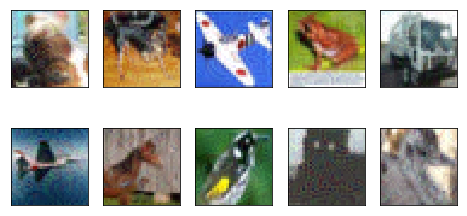


[[ 0.86086494  0.45774978 -0.04080509  0.42361343  0.22738311  0.36224753
   0.41933003  0.54379052  0.54480875  0.7476331 ]
 [ 0.6208269   0.32305709  0.25822848  0.12950258  0.16053845  0.56330878
   0.44187349  0.36415511  0.60530257  1.31449234]]
<NDArray 2x10 @gpu(0)>

[[-0.00081484  0.00033939  0.01105584 -0.01771183  0.04914688 -0.0776163
   0.0074151  -0.00136637 -0.04334011 -0.01749903]
 [ 0.02110897  0.00915922  0.01287662  0.00286914 -0.04126899 -0.0169199
   0.02211018  0.05105556  0.09108437  0.07623332]]
<NDArray 2x10 @gpu(0)>
iter: 100 loss: -33.3837
-33.3837


In [10]:
show_data(data[:10], False)
backgrad_data, (loss,) = generate_backgrad_data(net, data.copy(), label, max_iters=100, lr=0.1, iter_log=True, clip=False)
print loss

## 3.3 other implement

In [11]:
if False:
    data_dict = gluon.ParameterDict()
    data_param = gluon.Parameter('data')
    data_param.set_data(data)
    data_dict.update({'data': data_param})
    data_dict['data'].set_data(data)
    trainer = gluon.Trainer(data_dict, 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
    with autograd.record():
        output = net(data.as_in_context(ctx))
        loss = -loss_f(output, label.as_in_context(ctx))
    print data_dict['data'].data()
    loss.backward()
    #SGD(data, 0.1)
    import mxnet.optimizer as opt
    optimizer = opt.create('sgd', **{'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})#, param_dict=param_dict)
    updater = opt.get_updater(optimizer)

# 4. define train function

In [6]:
"""
train
"""
import datetime
import utils
import sys
from random import random

def abs_mean(W):
    return nd.mean(nd.abs(W)).asscalar()

def in_list(e, l):
    for i in l:
        if i == e:
            return True
    else:
        return False

def train(net, train_data, valid_data, num_epochs, lr, lr_period, 
          lr_decay, wd, ctx, w_key, output_file=None, verbose=False, loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), 
          use_mixup=False, mixup_alpha=0.2, back_grad_args=None):
    
    def train_batch(data, label, i, use_backgrad):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        # generate backgrad data
        if use_backgrad:
            args = back_grad_args
            args['prob'] = args.get('prob', 1)      # prob to use back grad data argument to prove origin data is used.
            if random() <= args['prob']:
                args['max_iters'], args['lr'] = args.get('max_iters', 60), args.get('lr', 0.1)
                data, _ = generate_backgrad_data(args['net'], data, label, args['max_iters'], args['lr'], iter_log=False)
                if args.has_key('show_iters') and i % args['show_iters'] == 0:
                    show_data(data[:5])
                
        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        _loss = nd.mean(loss).asscalar()
        if not use_mixup:
            _acc = utils.accuracy(output, label)
        else:
            _acc = None

        if verbose and i % 100 == 0:
            print " # iter", i,
            print "loss %.5f" % _loss, 
            if not use_mixup: print "acc %.5f" % _acc,
            print "w (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.data()),
            print ") g (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.grad()),
            print ")"
        return _loss, _acc
            
    if output_file is None:
        output_file = sys.stdout
        stdout = sys.stdout
    else:
        output_file = open(output_file, "w")
        stdout = sys.stdout
        sys.stdout = output_file
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    prev_time = datetime.datetime.now()
    
    if verbose:
        print " #", utils.evaluate_accuracy(valid_data, net, ctx)
    
    i = 0
    for epoch in range(num_epochs):
        train_loss = 0.
        train_acc = 0.
        if in_list(epoch, lr_period):
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        
        # back grad
        use_backgrad = False
        if back_grad_args is not None:
            args = back_grad_args
            if args.has_key('take_turn'):
                args['take_turn'] = not args['take_turn'] # only odd epoch(start 0) will use back grad

            if (not args.has_key('take_turn')) or args['take_turn'] == True:
                print "# back grad turn." 
                use_backgrad = True
        
        # mixup
        if not use_mixup:
            for data, label in train_data:
                _loss, _acc = train_batch(data, label, i, use_backgrad)
                train_loss += _loss
                train_acc += _acc
                i += 1
        else:
            for x, y in train_data:
                l = x.shape[0] / 2
                data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
                _loss, _ = train_batch(data, label, i, use_backgrad)
                train_loss += _loss
                i += 1
        
        # log info
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        if train_acc < 1e-6:
            train_acc = utils.evaluate_accuracy(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc = utils.evaluate_accuracy(valid_data, net, ctx)
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f, valid_acc %.4f" 
                         % (epoch, train_loss, train_acc, valid_acc))
        else:
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f"
                        % (epoch, train_loss, train_acc))
        prev_time = cur_time
        output_file.write(epoch_str + ", " + time_str + ",lr " + str(trainer.learning_rate) + "\n")
        output_file.flush()  # to disk only when flush or close
    if output_file != stdout:
        sys.stdout = stdout
        output_file.close()

# 5. get net and do EXP

## 5.1 baseline: general lr policy train my resnet18

In [9]:
num_epochs = 200
batch_size = 128
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_me_200e")

epoch 0, loss 1.62887, train_acc 0.3930, valid_acc 0.4363, Time 00:00:20,lr 0.1
epoch 1, loss 1.08034, train_acc 0.6125, valid_acc 0.6133, Time 00:00:21,lr 0.1
epoch 2, loss 0.82164, train_acc 0.7100, valid_acc 0.7070, Time 00:00:21,lr 0.1
epoch 3, loss 0.67574, train_acc 0.7648, valid_acc 0.7789, Time 00:00:22,lr 0.1
epoch 4, loss 0.58858, train_acc 0.7975, valid_acc 0.7726, Time 00:00:22,lr 0.1
epoch 5, loss 0.52661, train_acc 0.8185, valid_acc 0.8016, Time 00:00:22,lr 0.1
epoch 6, loss 0.47527, train_acc 0.8352, valid_acc 0.7996, Time 00:00:22,lr 0.1
epoch 7, loss 0.44764, train_acc 0.8469, valid_acc 0.8222, Time 00:00:22,lr 0.1
epoch 8, loss 0.42025, train_acc 0.8553, valid_acc 0.8307, Time 00:00:22,lr 0.1
epoch 9, loss 0.39904, train_acc 0.8618, valid_acc 0.8536, Time 00:00:22,lr 0.1
epoch 10, loss 0.37335, train_acc 0.8715, valid_acc 0.8515, Time 00:00:22,lr 0.1
epoch 11, loss 0.35385, train_acc 0.8768, valid_acc 0.8310, Time 00:00:22,lr 0.1
epoch 12, loss 0.34593, train_acc 0.88

epoch 101, loss 0.00982, train_acc 0.9976, valid_acc 0.9349, Time 00:00:22,lr 0.01
epoch 102, loss 0.00977, train_acc 0.9977, valid_acc 0.9351, Time 00:00:22,lr 0.01
epoch 103, loss 0.00842, train_acc 0.9982, valid_acc 0.9361, Time 00:00:22,lr 0.01
epoch 104, loss 0.00899, train_acc 0.9978, valid_acc 0.9353, Time 00:00:22,lr 0.01
epoch 105, loss 0.00825, train_acc 0.9981, valid_acc 0.9362, Time 00:00:22,lr 0.01
epoch 106, loss 0.00880, train_acc 0.9981, valid_acc 0.9364, Time 00:00:22,lr 0.01
epoch 107, loss 0.00761, train_acc 0.9981, valid_acc 0.9362, Time 00:00:22,lr 0.01
epoch 108, loss 0.00733, train_acc 0.9982, valid_acc 0.9346, Time 00:00:22,lr 0.01
epoch 109, loss 0.00803, train_acc 0.9981, valid_acc 0.9351, Time 00:00:22,lr 0.01
epoch 110, loss 0.00702, train_acc 0.9985, valid_acc 0.9346, Time 00:00:22,lr 0.01
epoch 111, loss 0.00748, train_acc 0.9982, valid_acc 0.9356, Time 00:00:22,lr 0.01
epoch 112, loss 0.00720, train_acc 0.9985, valid_acc 0.9345, Time 00:00:22,lr 0.01
epoc

## 5.2 train with saved backgrad image of resnet18_me_200e

In [16]:
num_epochs = 200
batch_size = 128
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4, 
                                     pathes=['/home/hui/dataset/CIFAR10/backgrad/resnet18_me_200e_iter15'])
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_me_200e_backgrad_3")

epoch 0, loss 1.68700, train_acc 0.3697, valid_acc 0.4790, Time 00:12:12,lr 0.1
epoch 1, loss 1.21249, train_acc 0.5590, valid_acc 0.6115, Time 00:00:21,lr 0.1
epoch 2, loss 0.96120, train_acc 0.6585, valid_acc 0.6740, Time 00:00:21,lr 0.1
epoch 3, loss 0.78946, train_acc 0.7242, valid_acc 0.6876, Time 00:00:21,lr 0.1
epoch 4, loss 0.65141, train_acc 0.7751, valid_acc 0.6739, Time 00:00:21,lr 0.1
epoch 5, loss 0.56812, train_acc 0.8050, valid_acc 0.7586, Time 00:00:21,lr 0.1
epoch 6, loss 0.51354, train_acc 0.8225, valid_acc 0.7785, Time 00:00:21,lr 0.1
epoch 7, loss 0.46963, train_acc 0.8397, valid_acc 0.7518, Time 00:00:21,lr 0.1
epoch 8, loss 0.43148, train_acc 0.8528, valid_acc 0.7518, Time 00:00:22,lr 0.1
epoch 9, loss 0.39796, train_acc 0.8622, valid_acc 0.7824, Time 00:00:22,lr 0.1
epoch 10, loss 0.35335, train_acc 0.8810, valid_acc 0.7787, Time 00:00:22,lr 0.1
epoch 11, loss 0.31605, train_acc 0.8910, valid_acc 0.7632, Time 00:00:22,lr 0.1
epoch 12, loss 0.29044, train_acc 0.90

epoch 101, loss 0.00527, train_acc 0.9988, valid_acc 0.7984, Time 00:00:22,lr 0.01
epoch 102, loss 0.00546, train_acc 0.9989, valid_acc 0.8011, Time 00:00:22,lr 0.01
epoch 103, loss 0.00526, train_acc 0.9989, valid_acc 0.8002, Time 00:00:22,lr 0.01
epoch 104, loss 0.00492, train_acc 0.9989, valid_acc 0.7951, Time 00:00:22,lr 0.01
epoch 105, loss 0.00567, train_acc 0.9988, valid_acc 0.8045, Time 00:00:22,lr 0.01
epoch 106, loss 0.00502, train_acc 0.9991, valid_acc 0.7952, Time 00:00:22,lr 0.01
epoch 107, loss 0.00513, train_acc 0.9989, valid_acc 0.8072, Time 00:00:22,lr 0.01
epoch 108, loss 0.00452, train_acc 0.9992, valid_acc 0.7961, Time 00:00:22,lr 0.01
epoch 109, loss 0.00439, train_acc 0.9991, valid_acc 0.7985, Time 00:00:22,lr 0.01
epoch 110, loss 0.00445, train_acc 0.9992, valid_acc 0.7927, Time 00:00:22,lr 0.01
epoch 111, loss 0.00443, train_acc 0.9993, valid_acc 0.8048, Time 00:00:22,lr 0.01
epoch 112, loss 0.00408, train_acc 0.9992, valid_acc 0.8079, Time 00:00:22,lr 0.01
epoc

In [8]:
num_epochs = 200
batch_size = 128
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4, 
                                     pathes=['/home/hui/dataset/CIFAR10/backgrad/resnet18_me_200e_iter15', 
                                            "/home/hui/dataset/CIFAR10/origin"])
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_me_200e_backgrad")

epoch 0, loss 1.39238, train_acc 0.4844, valid_acc 0.6332, Time 00:14:24,lr 0.1
epoch 1, loss 0.84304, train_acc 0.7023, valid_acc 0.7136, Time 00:10:13,lr 0.1
epoch 2, loss 0.63172, train_acc 0.7793, valid_acc 0.7828, Time 00:01:41,lr 0.1
epoch 3, loss 0.52173, train_acc 0.8190, valid_acc 0.8048, Time 00:00:41,lr 0.1
epoch 4, loss 0.45311, train_acc 0.8420, valid_acc 0.8023, Time 00:00:41,lr 0.1
epoch 5, loss 0.40725, train_acc 0.8590, valid_acc 0.8045, Time 00:00:42,lr 0.1
epoch 6, loss 0.37400, train_acc 0.8712, valid_acc 0.8370, Time 00:00:42,lr 0.1
epoch 7, loss 0.35129, train_acc 0.8779, valid_acc 0.7983, Time 00:00:42,lr 0.1
epoch 8, loss 0.32845, train_acc 0.8851, valid_acc 0.8192, Time 00:00:42,lr 0.1
epoch 9, loss 0.30751, train_acc 0.8940, valid_acc 0.8070, Time 00:00:42,lr 0.1
epoch 10, loss 0.29290, train_acc 0.8981, valid_acc 0.8497, Time 00:00:42,lr 0.1
epoch 11, loss 0.28240, train_acc 0.9011, valid_acc 0.8540, Time 00:00:42,lr 0.1
epoch 12, loss 0.26980, train_acc 0.90

epoch 101, loss 0.00600, train_acc 0.9986, valid_acc 0.9272, Time 00:00:42,lr 0.01
epoch 102, loss 0.00580, train_acc 0.9988, valid_acc 0.9287, Time 00:00:42,lr 0.01
epoch 103, loss 0.00567, train_acc 0.9988, valid_acc 0.9277, Time 00:00:42,lr 0.01
epoch 104, loss 0.00548, train_acc 0.9989, valid_acc 0.9280, Time 00:00:42,lr 0.01
epoch 105, loss 0.00564, train_acc 0.9987, valid_acc 0.9242, Time 00:00:42,lr 0.01
epoch 106, loss 0.00499, train_acc 0.9990, valid_acc 0.9259, Time 00:00:42,lr 0.01
epoch 107, loss 0.00483, train_acc 0.9990, valid_acc 0.9253, Time 00:00:42,lr 0.01
epoch 108, loss 0.00501, train_acc 0.9991, valid_acc 0.9268, Time 00:00:42,lr 0.01
epoch 109, loss 0.00455, train_acc 0.9993, valid_acc 0.9289, Time 00:00:42,lr 0.01
epoch 110, loss 0.00459, train_acc 0.9992, valid_acc 0.9276, Time 00:00:42,lr 0.01
epoch 111, loss 0.00443, train_acc 0.9993, valid_acc 0.9293, Time 00:00:42,lr 0.01
epoch 112, loss 0.00456, train_acc 0.9991, valid_acc 0.9271, Time 00:00:42,lr 0.01
epoc

In [7]:
num_epochs = 200
batch_size = 128
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()
arrayds_dir = '/home/hui/dataset/CIFAR10/arraydataset/'

# train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4, 
#                                      pathes=['/home/hui/dataset/CIFAR10/backgrad/resnet18_me_200e_iter10', 
#                                             "/home/hui/dataset/CIFAR10/origin"])
train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4, 
                                     pathes=[arrayds_dir + 'backgrad_resnet18_me_200e_iter10.ndarray', 
                                             arrayds_dir + "origin.ndarray"], arrayds=True)

net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_me_200e_backgrad_iter10")

epoch 0, loss 1.46888, train_acc 0.4564, valid_acc 0.5421, Time 00:00:45,lr 0.1
epoch 1, loss 0.87556, train_acc 0.6907, valid_acc 0.7035, Time 00:00:40,lr 0.1
epoch 2, loss 0.63554, train_acc 0.7800, valid_acc 0.7676, Time 00:00:41,lr 0.1
epoch 3, loss 0.51398, train_acc 0.8221, valid_acc 0.8004, Time 00:00:41,lr 0.1
epoch 4, loss 0.44164, train_acc 0.8467, valid_acc 0.7872, Time 00:00:42,lr 0.1
epoch 5, loss 0.39730, train_acc 0.8628, valid_acc 0.7623, Time 00:00:42,lr 0.1
epoch 6, loss 0.36283, train_acc 0.8752, valid_acc 0.7910, Time 00:00:42,lr 0.1
epoch 7, loss 0.34144, train_acc 0.8827, valid_acc 0.8381, Time 00:00:42,lr 0.1
epoch 8, loss 0.31793, train_acc 0.8901, valid_acc 0.8591, Time 00:00:42,lr 0.1
epoch 9, loss 0.29403, train_acc 0.8978, valid_acc 0.7898, Time 00:00:42,lr 0.1
epoch 10, loss 0.28417, train_acc 0.9009, valid_acc 0.8536, Time 00:00:42,lr 0.1
epoch 11, loss 0.27168, train_acc 0.9059, valid_acc 0.8697, Time 00:00:42,lr 0.1
epoch 12, loss 0.26154, train_acc 0.90

epoch 101, loss 0.00581, train_acc 0.9988, valid_acc 0.9264, Time 00:00:42,lr 0.01
epoch 102, loss 0.00549, train_acc 0.9987, valid_acc 0.9261, Time 00:00:42,lr 0.01
epoch 103, loss 0.00546, train_acc 0.9988, valid_acc 0.9263, Time 00:00:42,lr 0.01
epoch 104, loss 0.00476, train_acc 0.9991, valid_acc 0.9272, Time 00:00:42,lr 0.01
epoch 105, loss 0.00533, train_acc 0.9988, valid_acc 0.9266, Time 00:00:42,lr 0.01
epoch 106, loss 0.00499, train_acc 0.9990, valid_acc 0.9256, Time 00:00:42,lr 0.01
epoch 107, loss 0.00477, train_acc 0.9991, valid_acc 0.9277, Time 00:00:42,lr 0.01
epoch 108, loss 0.00435, train_acc 0.9993, valid_acc 0.9275, Time 00:00:42,lr 0.01
epoch 109, loss 0.00391, train_acc 0.9994, valid_acc 0.9277, Time 00:00:42,lr 0.01
epoch 110, loss 0.00426, train_acc 0.9992, valid_acc 0.9268, Time 00:00:42,lr 0.01
epoch 111, loss 0.00392, train_acc 0.9994, valid_acc 0.9270, Time 00:00:42,lr 0.01
epoch 112, loss 0.00457, train_acc 0.9991, valid_acc 0.9275, Time 00:00:42,lr 0.01
epoc

### 5.2.1
```
1. origin net show very bad acc in back grad image, means back grad images is blind for origin net(hard sample)
2. net train with adding back grad image has good acc in back grad image, means:
    2.1 the net has ability to recongnize back grad image.(it can not recognize them cause have not seen them, not cause net can not learning to recognize them.)
3. net train with adding back grad image(iter 15) can also have good acc in back grad image(iter 10), means the direction of back grad image change from origin image is stable and the result image is stable.
```

In [8]:
train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4, 
                                     pathes=[arrayds_dir + 'backgrad_resnet18_me_200e_iter10.ndarray']
                                     , arrayds=True)

In [13]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
net.load_params("../../models/resnet18_me_200e", ctx=ctx)

print "backgrad image acc for origin net: ", utils.evaluate_accuracy(train_data, net, ctx)

backgrad image acc for origin net:  0.443530210982


In [14]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
net.load_params("../../models/resnet18_me_200e_backgrad_iter10", ctx=ctx)

print "backgrad image acc for net trained with backgrad_iter10: ", utils.evaluate_accuracy(train_data, net, ctx)

backgrad image acc for net trained with backgrad_iter10:  1.0


In [15]:
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
net.load_params("../../models/resnet18_me_200e_backgrad", ctx=ctx) # iter15

print "backgrad image acc for net trained with backgrad_iter15: ", utils.evaluate_accuracy(train_data, net, ctx)

backgrad image acc for net trained with backgrad_iter15:  0.999300671355
